In [7]:
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, dct, idct
from scipy.io.wavfile import read
import IPython.display as ipd

In [8]:
def read_sound(file):
  """ read a mono wav sound file, assuming is mono, and convert it to a floating point array
    Args:
      file (str): File name
    Returns:
      sound_array (numpy.array): Array of samples as floating point values between -1 and 1
      sampling_rate (int): Sampling rate
  """
  # read sound file
  sampling_rate, x = read(file)
  # convert to floating point values between -1 and 1, assuming x are 16 bit integers
  sound_array = np.float32(x) / 2**15
  return sound_array, sampling_rate

def display_sound(sound_array, sampling_rate=44100):
  """ Display signal sound_array
    Args:
      sound_array (numpy.array): Array of samples
      sampling_rate (int): Sampling rate
  """
  # plot the waveform of the sound
  plt.figure(0, figsize=(10, 4))
  time_indexes = np.arange(0, sound_array.size/sampling_rate, 1.0/sampling_rate)
  plt.plot(time_indexes, sound_array)
  plt.xlabel('time (seconds)')
  plt.ylabel('amplitude')
  plt.show()
  # play the sound
  ipd.display(ipd.Audio(data=sound_array, rate=sampling_rate))

def display_spectrogram_stft(sound_array, fft_size=512, sampling_rate=44100):
  # initialize the output spectrogram
  magnitude_spectrogram = []
  sample_index = 0
  # iterate over the input sound computing a sequence of spectra
  while sample_index < sound_array.size-fft_size:
    spectrum = fft(sound_array[sample_index:sample_index+fft_size])
    magnitude_spectrum = 20*np.log10(abs(spectrum[:spectrum.size//2]))
    magnitude_spectrogram.append(magnitude_spectrum)
    sample_index += fft_size

  # plot the magnitude sspectrogram
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(magnitude_spectrogram), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

In [9]:
# functions needed to compute mdct

N = 1024

#The D(z) matrix:
def Dmatrix(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[0:int(N/2)]=Dmatrix.z
    Dmatrix.z=samples[0:int(N/2)]
    out[int(N/2):N]=samples[int(N/2):N]
    return out

Dmatrix.z=np.zeros(N//2)

#The inverse D(z) matrix:
def Dmatrixinv(samples):
    #implementation of the delay matrix D(z)
    N = len(samples)
    out=np.zeros(N)
    out[int(N/2):N]=Dmatrixinv.z
    Dmatrixinv.z=samples[int(N/2):N]
    out[0:int(N/2)]=samples[0:int(N/2)]
    return out

Dmatrixinv.z=np.zeros(int(N/2))

#The F Matrix:
fcoeff=np.sin(np.pi/(2*N)*(np.arange(0,2*N)+0.5))
Fmatrix=np.zeros((N,N))
Fmatrix[0:int(N/2),0:int(N/2)]=np.fliplr(np.diag(fcoeff[0:int(N/2)]))
Fmatrix[int(N/2):N,0:int(N/2)]=np.diag(fcoeff[int(N/2):N])
Fmatrix[0:int(N/2),int(N/2):N]=np.diag(fcoeff[N:int(N+N/2)])
Fmatrix[int(N/2):N,int(N/2):N]=-np.fliplr(np.diag(fcoeff[int(N+N/2):(2*N)]))

#The inverse F matrix:
Finv=np.linalg.inv(Fmatrix)

#The complete MDCT, Analysis:
def MDCT(samples):
    y=np.dot(samples,Fmatrix)
    y=Dmatrix(y)
    y=dct(y,type=4)
    return y

#The inverse MDCT, synthesis:
def MDCTinv(y):
    #inverse DCT4 is identical to DCT4:
    x=idct(y,type=4)/(2*len(y))
    #inverse D(z) matrix
    x=Dmatrixinv(x)
    #inverse F matrix
    x=np.dot(x,Finv)
    return x

def display_spectrogram_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N

  Xf = np.array(Xf)
  plt.figure(figsize=(10, 5))
  plt.pcolormesh(np.transpose(20*np.log10(np.abs(Xf))), shading='auto', cmap='inferno')
  plt.colorbar(format='%+2.0f dB')
  plt.xlabel('frames')
  plt.ylabel('bins')
  plt.show()

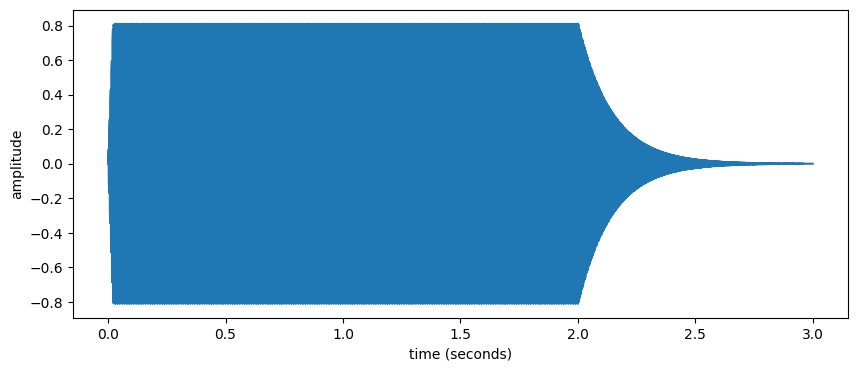

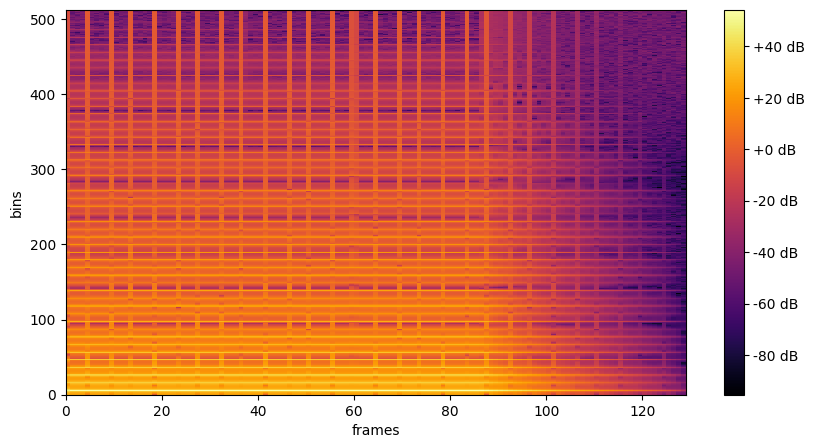

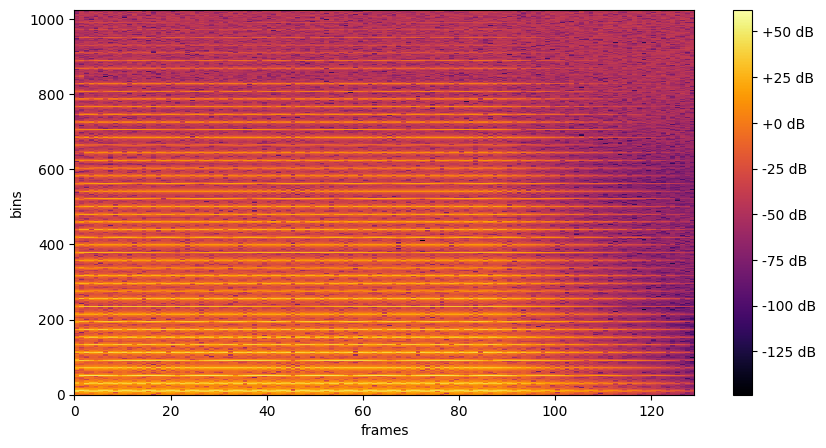

In [10]:
x, fs = read_sound('../sounds/synthetic.wav')
display_sound(x, fs)

display_spectrogram_stft(x, N, 1)

display_spectrogram_mcdt(x, N, fs)

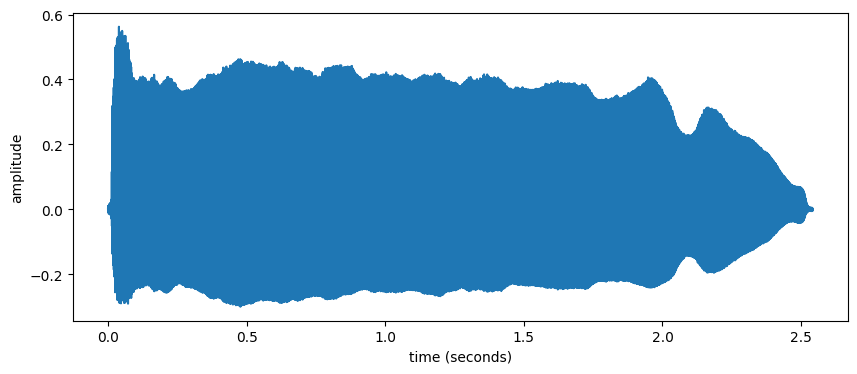

/var/folders/l3/g0bl2h853g72yx1shwfkd7w00000gp/T/ipykernel_37543/1218851749.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt


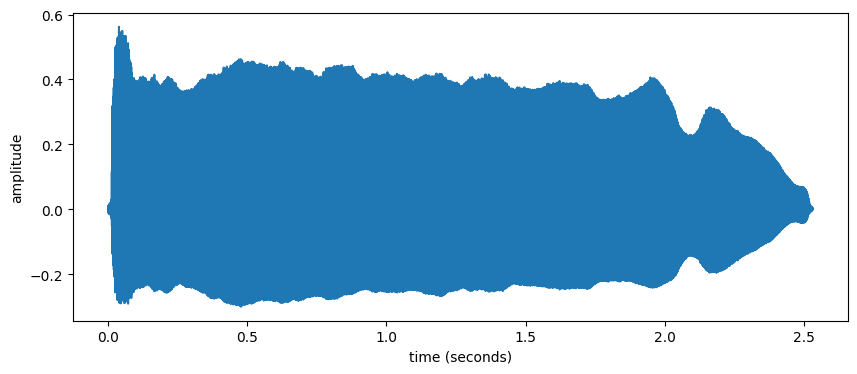

In [11]:
# perform STFT and inverse STFT

def compute_stft(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = fft(x[i:i+N])
    Xf.append(np.array(X))
    i += N
  return(np.array(Xf))

def compute_inverse_stft(Xf, fs=44100):
  i = 0
  y = np.zeros(len(Xf[0,:])*len(Xf[:,0]))
  for i in range(len(Xf[:,0])):
    yt = ifft(Xf[i,:])
    y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt
  return(y)

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

N = 1024
Xf = compute_stft(x, N, fs)
y = compute_inverse_stft(Xf, fs)
display_sound(y, fs)

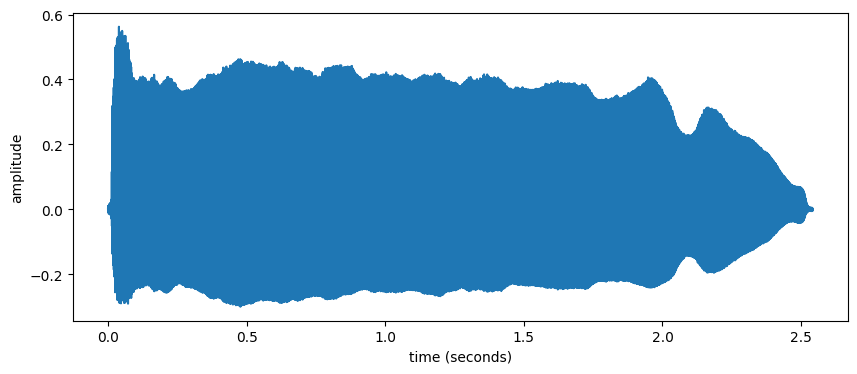

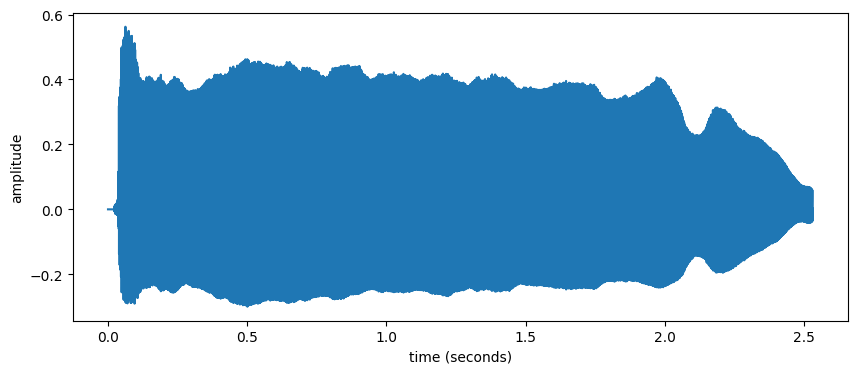

In [12]:
# perform MCDT and inverse MCDT

def compute_mcdt(x, N, fs=44100):
  i = 0
  Xf = []
  while i < x.size-N:
    X = MDCT(x[i:i+N])
    Xf.append(np.array(X))
    i += N
  return(np.array(Xf))

def compute_inverse_mcdt(Xf, fs=44100):
  i = 0
  y = np.zeros(len(Xf[0,:])*len(Xf[:,0]))
  for i in range(len(Xf[:,0])):
    yt = MDCTinv(Xf[i,:])
    y[i*len(Xf[0,:]):i*len(Xf[0,:])+len(yt)] = yt
  return(y)

x, fs = read_sound('../sounds/487465-trumpet.wav')
display_sound(x, fs)

N = 1024
Xf = compute_mcdt(x, N, fs)
y = compute_inverse_mcdt(Xf, fs)
display_sound(y, fs)